In [29]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)


In [30]:
import sys
import glob, os

# remove warnings
import warnings
warnings.filterwarnings('ignore')

from pyprojroot import here

# Add the project root to sys.path
sys.path.append(str(here()))

from hspc.config import get_config
config = get_config()

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

from collections import Counter

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score

In [33]:

from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import numpy as np

In [34]:
import random
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    
set_seed(42)

In [7]:
from tabpfn import TabPFNClassifier as tbp
import shapiq

# Load Data
Here we will load the data from IU and CU (Piccirillo)

In [35]:
dataset = pd.read_csv(here() / config.data_interim / 'd_p_h_combined_unnormalized.csv')
dataset

,Gender,Age,WBC,Hgb,Hct,Platelet Ct,Neut Pct,Lymphocyte Abs,Mono Pct,Lymph Pct,Eos Pct,Mono Abs,Neut Abs,Eos Abs,Day 1 CD34 Absolute per uL,Count,lab
0,1,39,11.2,14.6,43.5,328.0,64.5,2.9,7.4,25.5,1.9,0.8,7.2,0.2,100.0,1,Dipersio
1,0,57,6.5,14.5,42.9,280.0,48.1,2.7,5.9,41.1,4.0,0.4,3.1,0.3,71.0,1,Dipersio
2,1,43,4.4,15.0,43.9,299.0,58.0,1.3,10.0,28.7,2.7,0.4,2.6,0.1,87.0,1,Dipersio
3,0,50,6.7,14.2,40.6,243.0,56.4,2.0,7.7,29.8,4.8,0.5,3.8,0.3,27.0,0,Dipersio
4,0,32,9.8,13.3,39.2,373.0,65.1,2.6,6.4,26.5,1.7,0.6,6.4,0.2,31.0,0,Dipersio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1155,1,23,31.3,13.5,39.4,257.0,76.0,2.8,8.0,9.0,1.0,2.5,23.8,0.3,58.0,1,hurwitz
1156,1,56,37.0,15.4,44.9,233.0,77.0,4.4,7.0,12.0,1.0,2.6,28.5,0.4,59.0,1,hurwitz
1157,0,25,51.9,13.8,40.7,265.0,64.0,7.3,9.0,14.0,1.0,4.7,33.2,0.5,56.0,1,hurwitz
1158,1,22,51.0,14.6,42.9,250.0,89.0,4.1,2.0,8.0,1.0,1.0,45.3,0.5,174.0,1,hurwitz


In [36]:
dataset.lab.unique()

array(['Dipersio', 'Piccirillo', 'hurwitz'], dtype=object)

In [37]:
# drop all the rows belonging to lab Hurwitz and lab Piccirillo
dataset = dataset[~dataset['lab'].isin(['hurwitz', 'Piccirillo'])]

In [38]:
dataset.reset_index(drop=True, inplace=True)
dataset

,Gender,Age,WBC,Hgb,Hct,Platelet Ct,Neut Pct,Lymphocyte Abs,Mono Pct,Lymph Pct,Eos Pct,Mono Abs,Neut Abs,Eos Abs,Day 1 CD34 Absolute per uL,Count,lab
0,1,39,11.2,14.6,43.5,328.0,64.5,2.9,7.4,25.5,1.9,0.8,7.2,0.2,100.0,1,Dipersio
1,0,57,6.5,14.5,42.9,280.0,48.1,2.7,5.9,41.1,4.0,0.4,3.1,0.3,71.0,1,Dipersio
2,1,43,4.4,15.0,43.9,299.0,58.0,1.3,10.0,28.7,2.7,0.4,2.6,0.1,87.0,1,Dipersio
3,0,50,6.7,14.2,40.6,243.0,56.4,2.0,7.7,29.8,4.8,0.5,3.8,0.3,27.0,0,Dipersio
4,0,32,9.8,13.3,39.2,373.0,65.1,2.6,6.4,26.5,1.7,0.6,6.4,0.2,31.0,0,Dipersio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,1,42,6.4,14.4,42.4,230.0,57.0,2.2,7.0,34.0,2.0,0.4,3.6,0.1,66.0,1,Dipersio
795,1,53,7.5,13.9,41.2,246.0,64.0,2.2,4.0,30.0,2.0,0.3,4.8,0.2,68.0,1,Dipersio
796,1,41,7.8,17.4,50.5,227.0,55.0,3.0,4.0,39.0,1.0,0.3,4.3,0.1,55.0,1,Dipersio
797,0,33,4.0,11.6,34.1,210.0,42.0,1.9,8.0,46.0,3.0,0.3,1.7,0.1,60.0,1,Dipersio


In [39]:
cols_to_drop = ['Day 1 CD34 Absolute per uL', 'lab']
dataset = dataset.drop(cols_to_drop, axis=1)
dataset = dataset.dropna()

In [40]:
# remove all rows containing N/A and map samples to respective classes
dataset = dataset.dropna(axis=0, how='any')

In [41]:
# apply linear normalization
df_temp = dataset.iloc[:,:-1]
dataset.iloc[:,:-1] = (df_temp - df_temp.min()) / (df_temp.max() - df_temp.min())

In [42]:
# oversample the bad mobilizers to balance the dataset with SMOTE
X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1]
oversample = SMOTE(random_state=42)
X, y = oversample.fit_resample(X, y)


In [43]:
# convert y in to binary classes
y = (y > 0).astype(int)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

In [45]:
clf = tbp()
clf.fit(X_train, y_train)

TabPFNClassifier()

In [19]:
# save the model as a pickle file
import pickle
with open(here() / config.model_dl / 'tabpfn_model_integ.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [ ]:
prediction_prob = clf.predict_proba(X_test)
print('ROC AUC:', roc_auc_score(y_test, prediction_prob[:,1]))

# plot ROC curve
fpr, tpr, _ = roc_curve(y_test, prediction_prob[:,1])
roc_auc = auc(fpr, tpr)

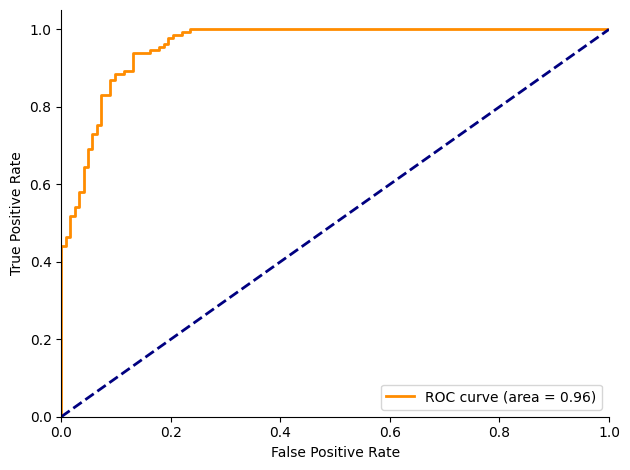

In [47]:

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.tight_layout()
sns.despine()
plt.savefig(here() / config.plots / 'model_results' / 'tabpfn_dip_trim' / 'roc_curve.png', dpi=300, bbox_inches='tight')
plt.savefig(here() / config.plots / 'model_results' / 'tabpfn_dip_trim' / 'roc_curve.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [48]:
# plot confusion matrix
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

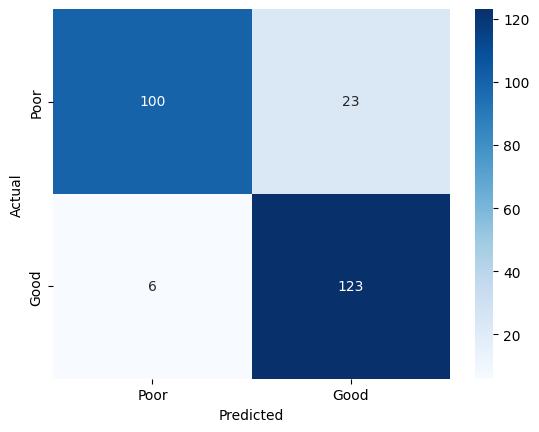

In [49]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Poor', 'Good'], yticklabels=['Poor', 'Good'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(here() / config.plots / 'model_results' / 'tabpfn_dip_trim' / 'confusion_matrix.png', dpi=500, bbox_inches='tight')
plt.savefig(here() / config.plots / 'model_results' / 'tabpfn_dip_trim' / 'confusion_matrix.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.81      0.87       123
           1       0.84      0.95      0.89       129

    accuracy                           0.88       252
   macro avg       0.89      0.88      0.88       252
weighted avg       0.89      0.88      0.88       252



In [23]:
# print the prediction probabilities of the first 10 samples
print("Prediction probabilities of the first 10 samples:")
for i in range(20):
    print(f"Sample {i+1}: {prediction_prob[i]}")
# print the actual labels of the first 10 samples
print("Actual labels of the first 10 samples:")
for i in range(20):
    print(f"Sample {i+1}: {y_test[i]}")
# print the predicted labels of the first 10 samples
print("Predicted labels of the first 10 samples:")
for i in range(20):
    print(f"Sample {i+1}: {y_pred[i]}")


Prediction probabilities of the first 10 samples:
Sample 1: [0.02917765 0.9708224 ]
Sample 2: [0.06797239 0.93202764]
Sample 3: [0.07636858 0.9236314 ]
Sample 4: [0.02687367 0.97312635]
Sample 5: [0.9700712  0.02992882]
Sample 6: [0.27063477 0.7293652 ]
Sample 7: [0.9958027 0.0041973]
Sample 8: [0.31842202 0.681578  ]
Sample 9: [0.8678645  0.13213557]
Sample 10: [9.9945414e-01 5.4586085e-04]
Sample 11: [0.07713972 0.92286026]
Sample 12: [9.9993318e-01 6.6796936e-05]
Sample 13: [0.05589321 0.9441068 ]
Sample 14: [0.9602357  0.03976423]
Sample 15: [0.69631493 0.30368504]
Sample 16: [0.01237796 0.987622  ]
Sample 17: [0.9986356 0.0013644]
Sample 18: [0.85042346 0.14957656]
Sample 19: [0.34263265 0.6573674 ]
Sample 20: [0.2656831  0.73431695]
Actual labels of the first 10 samples:
Sample 1: 1
Sample 2: 1
Sample 3: 1
Sample 4: 1
Sample 5: 0
Sample 6: 0
Sample 7: 0
Sample 8: 1
Sample 9: 0
Sample 10: 0
Sample 11: 1
Sample 12: 0
Sample 13: 1
Sample 14: 0
Sample 15: 0
Sample 16: 1
Sample 17: 0


In [27]:
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, AdaBoostRegressor
# from catboost import CatBoostClassifier, CatBoostRegressor

In [ ]:
# mlp = keras.models.load_model(here() / config.model_dl / 'hpd_auc_91_acc_84_loss_51_gp.keras')

In [51]:
# # Define models
# models = [
#     ('TabPFN', tbp(random_state=42)),
#     ('RandomForest', RandomForestClassifier(random_state=42)),
#     ('XGBoost', XGBClassifier(random_state=42)),
#     ('AdaBoost', AdaBoostClassifier(random_state=42)),
#     # ('MLP', mlp),
# ]

# # Calculate scores
# scoring = 'roc_auc_ovr' if len(np.unique(y)) > 2 else 'roc_auc'
# scores = {name: cross_val_score(model, X_train, y_train, cv=5, scoring=scoring, n_jobs=1, verbose=1).mean()
#           for name, model in models}

# # Plot results
# df = pd.DataFrame(list(scores.items()), columns=['Model', 'ROC AUC'])
# ax = df.plot(x='Model', y='ROC AUC', kind='bar', figsize=(10, 6))
# ax.set_ylim(df['ROC AUC'].min() * 0.995, min(1.0, df['ROC AUC'].max() * 1.005))
# # plt.grid(axis='y', linestyle='--')
# # add numbers on top of the bars
# for i, v in enumerate(df['ROC AUC']):
#     ax.text(i, v + 0.005, f"{v:.3f}", ha='center', va='bottom', fontsize=10)
# plt.xticks(rotation=45, ha='right')
# sns.despine()
# plt.tight_layout()
# ax.set_title('Model Comparison - 5-fold Cross-validation')

# SHAP Explanations

In [ ]:
from tabpfn_extensions import interpretability
from tabpfn import TabPFNClassifier





In [54]:
shap_values_df = pd.DataFrame({
    'Feature': ['Mono Abs', 'Neut Abs', 'WBC', 'Age', 'Neut Pct', 'Eos Abs', 'HGB', 'Platelet Ct', 'Mono Pct', 'Sum of 5 other features'],
    'SHAP_Value': [0.19, 0.09, 0.08, 0.07, 0.07, 0.06, 0.05, 0.04, 0.04, 0.11]
})


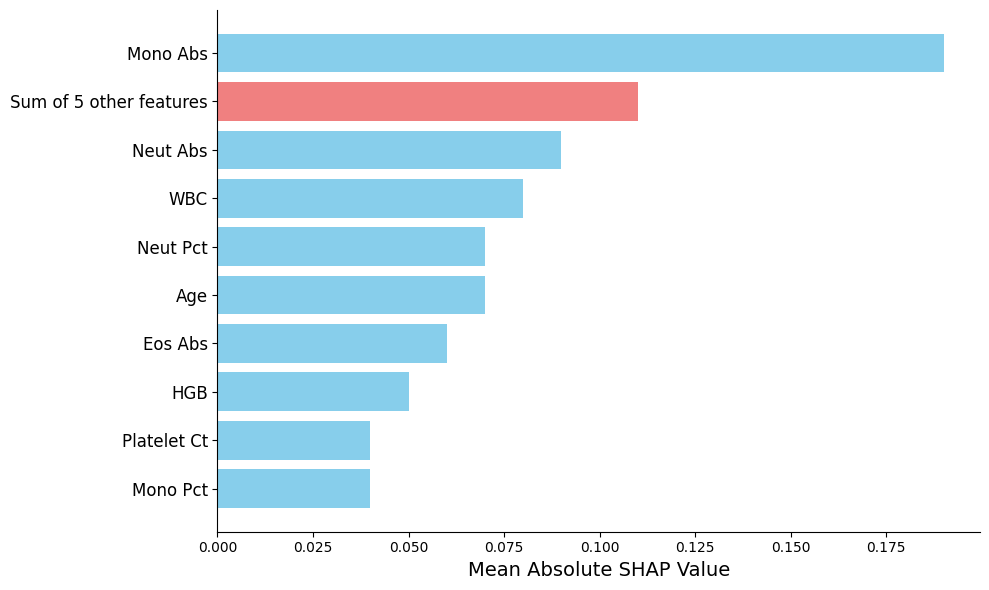

In [ ]:
# Sort by SHAP values in descending order
shap_values_df = shap_values_df.sort_values('SHAP_Value', ascending=False).reset_index(drop=True)

# Create horizontal bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(shap_values_df)), shap_values_df['SHAP_Value'], 
                color=['lightcoral' if x == 'Sum of 5 other features' else 'skyblue' for x in shap_values_df['Feature']])

# Customize the plot
plt.yticks(range(len(shap_values_df)), shap_values_df['Feature'], fontsize=12)
plt.xlabel('Mean Absolute SHAP Value', fontsize=14)
plt.gca().invert_yaxis()  # Top feature at top
plt.tight_layout()
sns.despine()
plt.show()

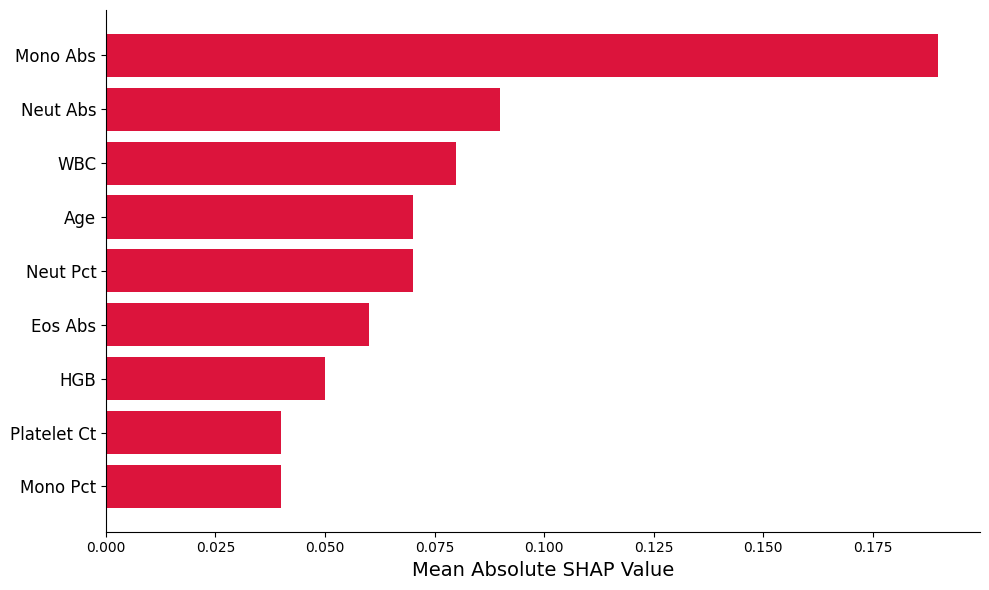

In [57]:
shap_values_df = pd.DataFrame({
    'Feature': ['Mono Abs', 'Neut Abs', 'WBC', 'Age', 'Neut Pct', 'Eos Abs', 'HGB', 'Platelet Ct', 'Mono Pct'],
    'SHAP_Value': [0.19, 0.09, 0.08, 0.07, 0.07, 0.06, 0.05, 0.04, 0.04]
})

# Sort by SHAP values in descending order
shap_values_df = shap_values_df.sort_values('SHAP_Value', ascending=False).reset_index(drop=True)

# Create horizontal bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(shap_values_df)), shap_values_df['SHAP_Value'], color='crimson')

# Customize the plot
plt.yticks(range(len(shap_values_df)), shap_values_df['Feature'], fontsize=12)
plt.xlabel('Mean Absolute SHAP Value', fontsize=14)
plt.gca().invert_yaxis()  # Top feature at top
plt.tight_layout()
sns.despine()
plt.savefig(here() / config.plots / 'model_results' / 'tabpfn_dip_trim' / 'shap_values_bar_plot.png', dpi=300, bbox_inches='tight')
plt.savefig(here() / config.plots / 'model_results' / 'tabpfn_dip_trim' / 'shap_values_bar_plot.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [25]:
feature_names = X.columns.tolist()

In [26]:

n_samples = 200

# Calculate SHAP values
shap_values = interpretability.shap.get_shap_values(
    estimator=clf,
    test_x=X_test[:n_samples],
    attribute_names=feature_names,
    algorithm="permutation",  # or "auto" for automatic selection
)


PermutationExplainer explainer: 201it [20:11:44, 363.52s/it]                            


In [27]:
# save shap values to a file
out = here() / config.data_interim / 'shap_values_dipersio_trimmed_tabpfn.npz'
np.savez(
    out,
    values=shap_values.values,
    base_values=shap_values.base_values,
    data=shap_values.data
)
print("saved to", out)

saved to c:\workspace_dl\data\interim\shap_values_dipersio_trimmed_tabpfn.npz


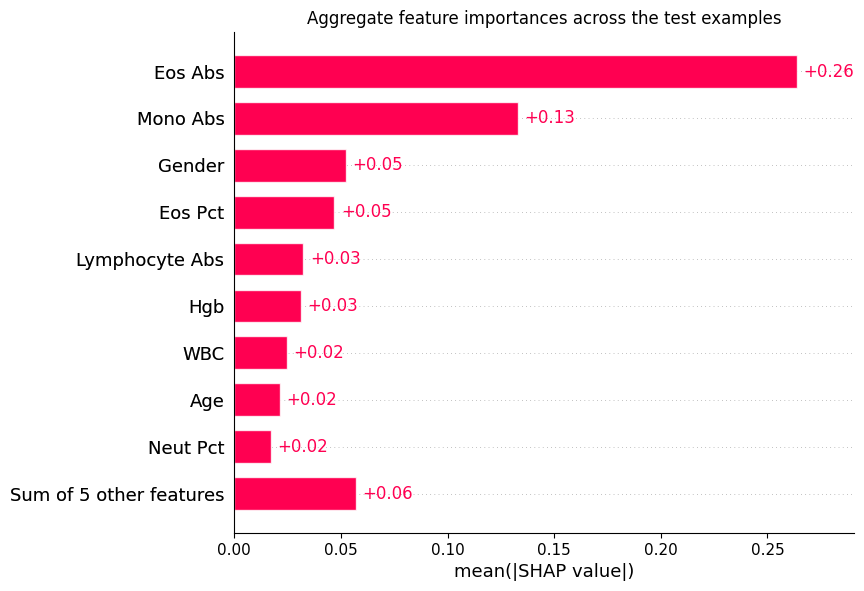

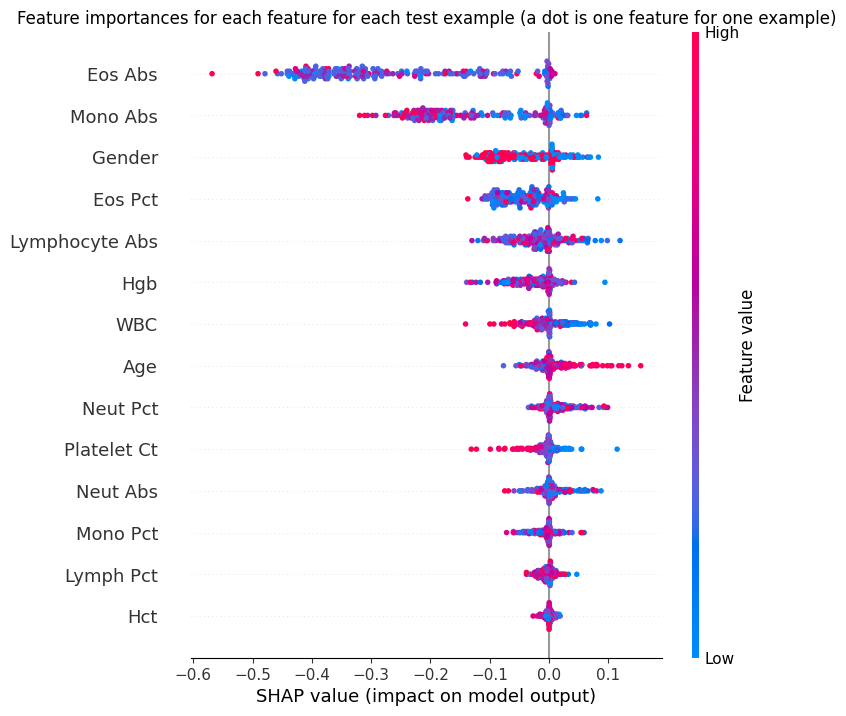

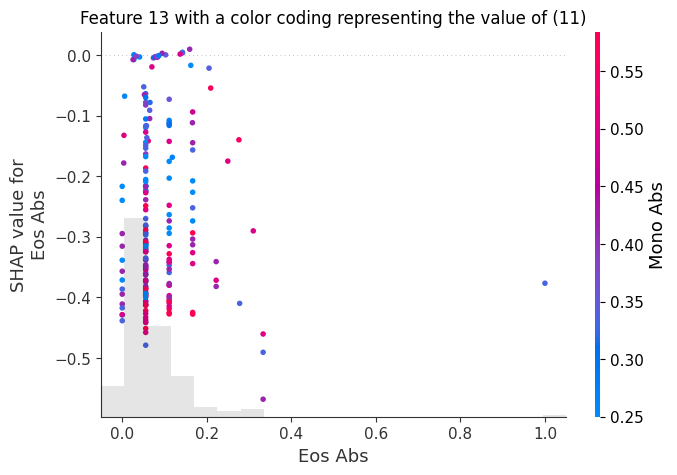

In [28]:
interpretability.shap.plot_shap(shap_values)